Loaded 168 embryos.
Analysis restricted to 289 time points (from 0.00h to 72.00h).
--- Analyzing: GV_to_GV vs GV_to_M1 ---
Significant time points found: 0


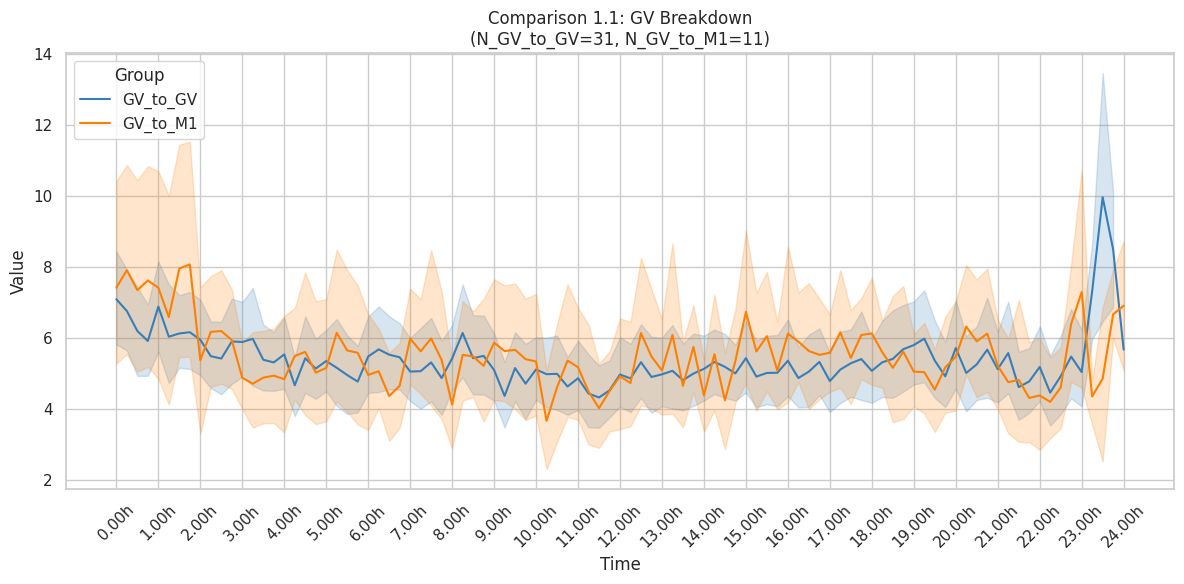

--- Analyzing: GV_to_GV vs GV_to_M2 ---
Significant time points found: 0


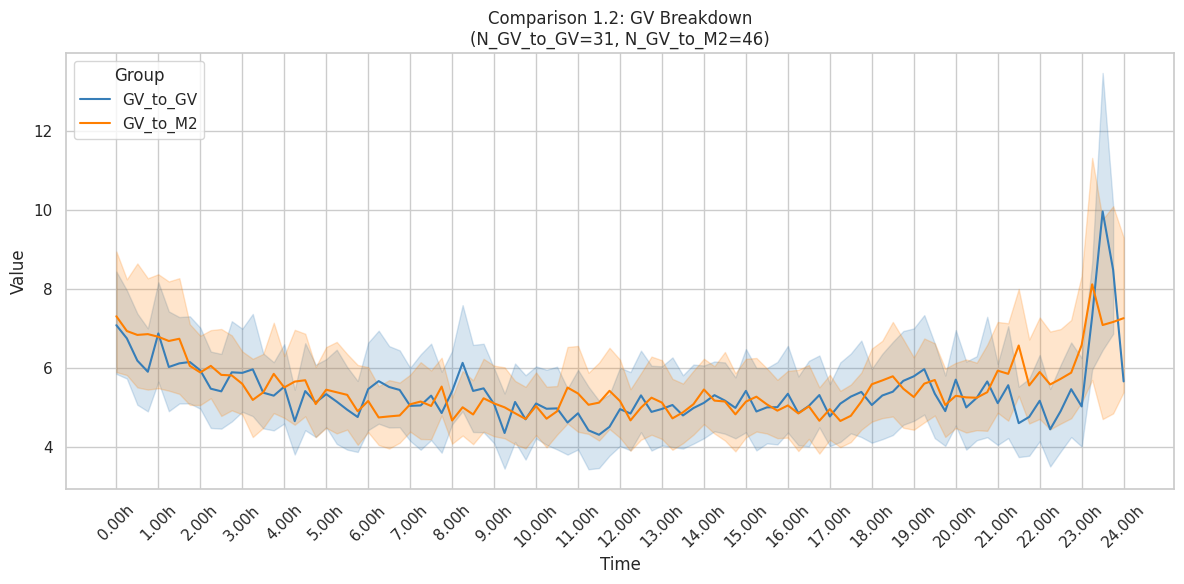

--- Analyzing: GV_to_M1 vs GV_to_M2 ---
Significant time points found: 0


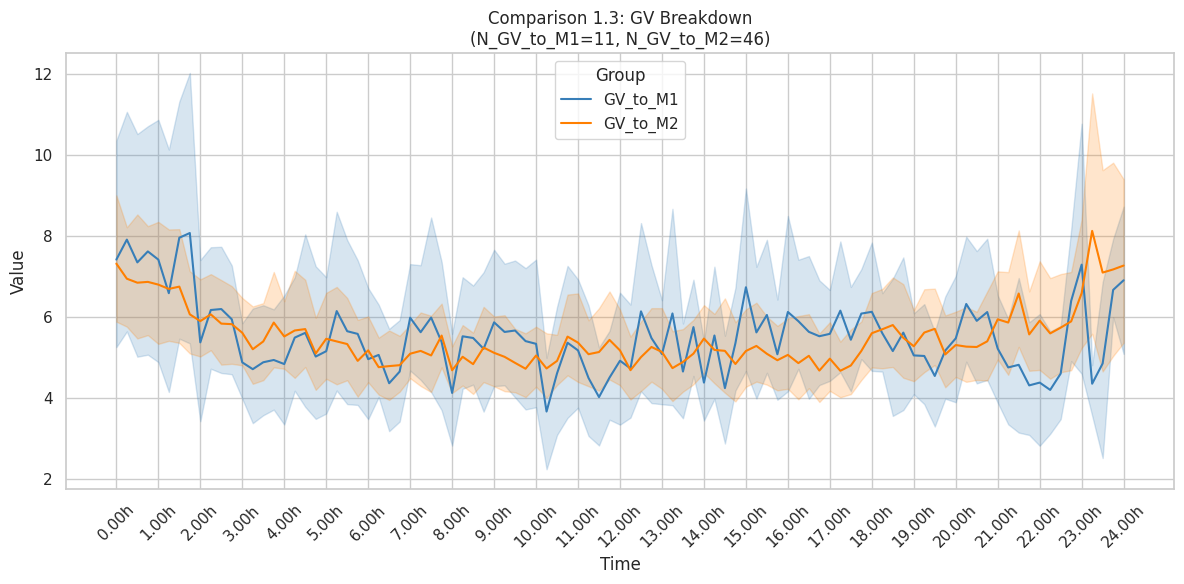

--- Analyzing: M2_to_blasto vs rM2_to_blasto ---
Significant time points found: 0


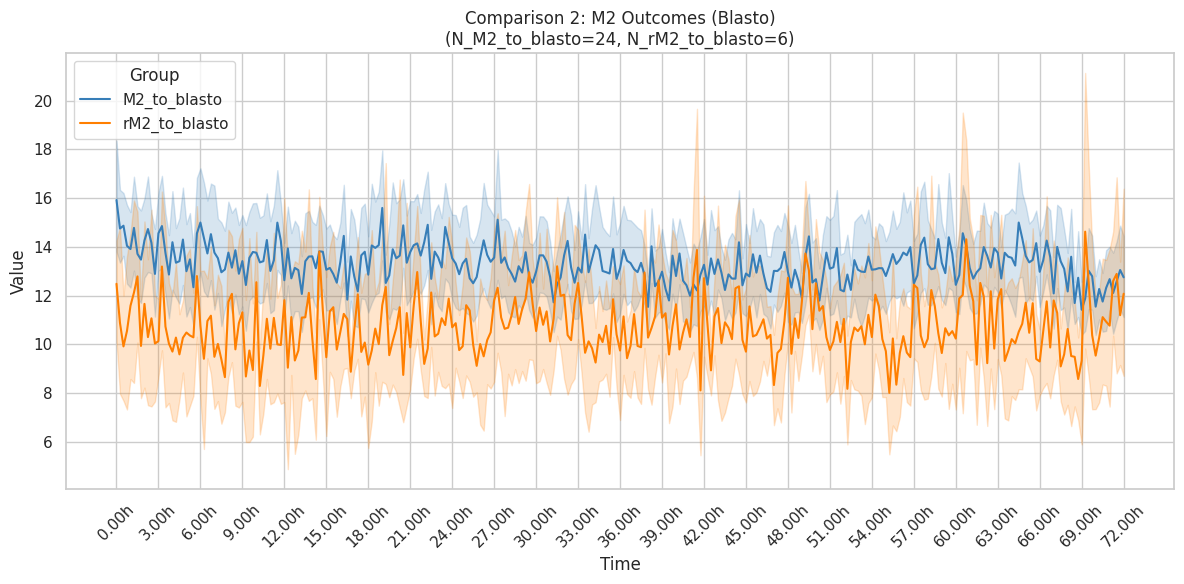

--- Analyzing: M2_to_no_blasto vs rM2_to_no_blasto ---
Significant time points found: 1
  Details of significant time points:
    - At 1.50h: p_raw = 0.00015 | p_adj = 0.04360


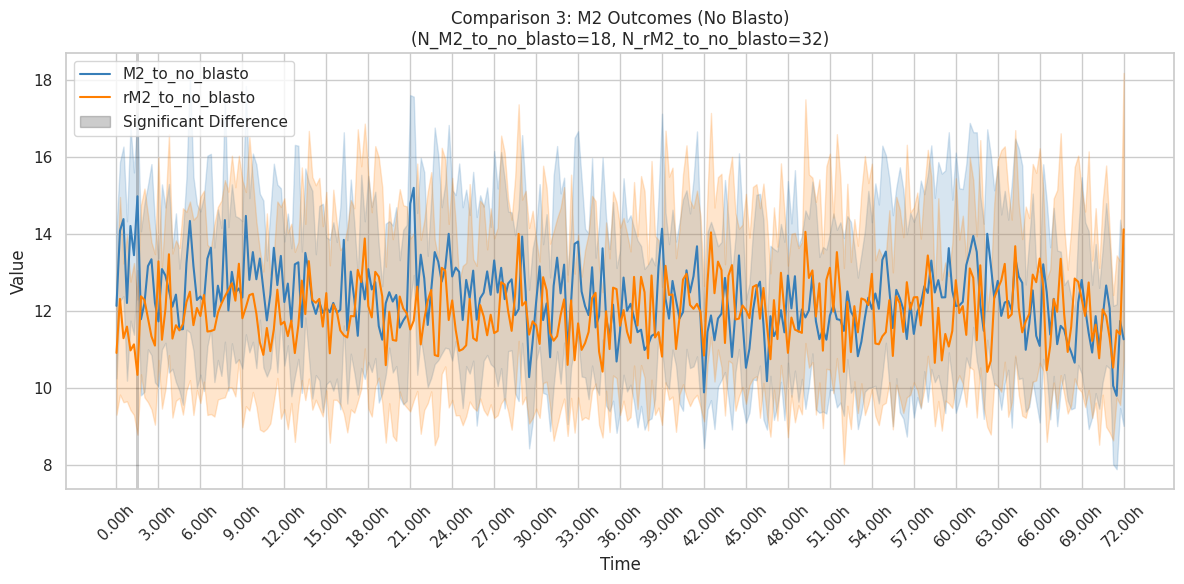

--- Analyzing: M2_Combined vs rM2_Combined ---
Significant time points found: 12
  Details of significant time points:
    - At 0.25h: p_raw = 0.00140 | p_adj = 0.04403
    - At 0.50h: p_raw = 0.00005 | p_adj = 0.01534
    - At 1.50h: p_raw = 0.00012 | p_adj = 0.01782
    - At 2.50h: p_raw = 0.00183 | p_adj = 0.04403
    - At 10.25h: p_raw = 0.00084 | p_adj = 0.04287
    - At 11.75h: p_raw = 0.00064 | p_adj = 0.04287
    - At 12.25h: p_raw = 0.00115 | p_adj = 0.04403
    - At 21.75h: p_raw = 0.00160 | p_adj = 0.04403
    - At 22.75h: p_raw = 0.00127 | p_adj = 0.04403
    - At 34.75h: p_raw = 0.00183 | p_adj = 0.04403
    - At 62.25h: p_raw = 0.00051 | p_adj = 0.04287
    - At 66.50h: p_raw = 0.00089 | p_adj = 0.04287


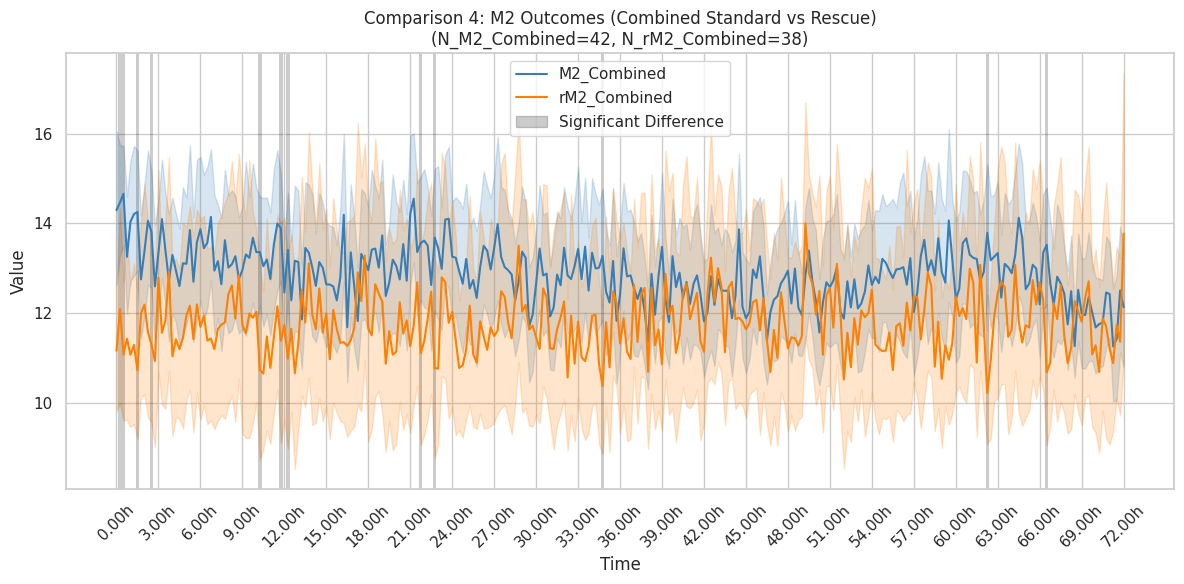

In [2]:
# %% [markdown]
# # Statistical Analysis of Time-Series: Embryo Metrics (0h - 24h)
# 
# **Goal:** Compare specific groups of embryos based on the 'Note' classification.
# **Method:** Mann-Whitney U Test (Point-wise) + Consecutive Filter + Mean/CI Visualization.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Settings for nice plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %%
# ---------------- CONFIGURATION ----------------
# NOTE: Changing this to sum_mean_mag as requested
INPUT_CSV = "/home/phd2/Scrivania/CorsoRepo/embryo_valencia/datasets/final_datasets/FinalDataset_sum_mean_mag.csv"
MAX_TIME_HOUR_GV = 24.0  # Cutoff time (included)
MAX_TIME_HOUR_BLASTO = 72.0  # Cutoff time (included)

# --- STATISTICAL SETTINGS ---
# Set to True for rigorous publication standards (FDR Correction).
# Set to False to find more trends (Raw P-values + Consecutive Filter).
STRICT_CORRECTION = True 

# If STRICT_CORRECTION is False, a signal must last this many time steps to be considered real.
# 2 steps * 15 min = 30 min duration.
MIN_CONSECUTIVE_STEPS = 2

# Load Data
try:
    df = pd.read_csv(INPUT_CSV, sep=';')
except FileNotFoundError:
    print(f"File not found: {INPUT_CSV}")
    # Fallback for demonstration if file name is different
    INPUT_CSV = "/home/phd2/Scrivania/CorsoRepo/cellPIV/datasets/Farneback/FinalDataset_vorticity.csv" 
    print(f"Falling back to: {INPUT_CSV}")
    df = pd.read_csv(INPUT_CSV, sep=';')

# Handle column name variations (BLASTO NY vs BLASTO_NY)
if 'BLASTO_NY' in df.columns:
    df.rename(columns={'BLASTO_NY': 'BLASTO NY'}, inplace=True)
df['BLASTO NY'] = pd.to_numeric(df['BLASTO NY'], errors='coerce')

# Ensure 'Note' column exists (remove whitespace)
if 'Note' in df.columns:
    df['Note'] = df['Note'].astype(str).str.strip()
else:
    print("ERROR: 'Note' column not found in CSV.")
    # Stop execution or handle error
    time_cols = [] 

# --- TIME COLUMN SELECTION (CUT AT 24H) ---
all_time_cols = [c for c in df.columns if c.endswith('h')]

selected_time_cols = []
for col in all_time_cols:
    try:
        # Check if the numeric part is <= the max between GV and Blasto
        val = float(col.replace('h', ''))
        if val <= max(MAX_TIME_HOUR_GV, MAX_TIME_HOUR_BLASTO):
            selected_time_cols.append(col)
    except ValueError:
        continue 

time_cols = selected_time_cols
print(f"Loaded {len(df)} embryos.")
print(f"Analysis restricted to {len(time_cols)} time points (from {time_cols[0]} to {time_cols[-1]}).")

# %% [markdown]
# ## Helper Functions

# %%
def perform_pointwise_stats(group_a, group_b, time_cols, strict=True, min_steps=1, alpha=0.05):
    """
    Runs Mann-Whitney U test for every time point.
    """
    p_values = []
    valid_times = []
    
    for t in time_cols:
        a_vals = group_a[t].dropna()
        b_vals = group_b[t].dropna()
        
        # Need at least 2 samples per group to run a test
        if len(a_vals) < 2 or len(b_vals) < 2:
            p_values.append(np.nan)
            valid_times.append(t)
            continue
            
        # Mann-Whitney U Test
        stat, p = mannwhitneyu(a_vals, b_vals, alternative='two-sided')
        p_values.append(p)
        valid_times.append(t)
    
    res_df = pd.DataFrame({'time': valid_times, 'p_raw': p_values})
    
    if strict:
        # --- OPTION A: STRICT FDR CORRECTION ---
        mask = ~np.isnan(res_df['p_raw'])
        if mask.sum() > 0:
            reject, p_corrected, _, _ = multipletests(res_df.loc[mask, 'p_raw'], alpha=alpha, method='fdr_bh')
            res_df.loc[mask, 'p_adj'] = p_corrected
            res_df.loc[mask, 'significant'] = reject
        else:
            res_df['significant'] = False
    else:
        # --- OPTION B: RAW P-VALUES + CONSECUTIVE FILTER ---
        # 1. Identify raw significant points
        res_df['significant'] = res_df['p_raw'] < alpha
        
        # 2. Apply Consecutive Filter
        sig_array = res_df['significant'].fillna(False).values
        cleaned_sig = np.zeros_like(sig_array, dtype=bool)
        
        count = 0
        start_idx = 0
        for i, is_sig in enumerate(sig_array):
            if is_sig:
                if count == 0: start_idx = i
                count += 1
            else:
                if count >= min_steps:
                    cleaned_sig[start_idx:i] = True
                count = 0
        # Check last sequence
        if count >= min_steps:
            cleaned_sig[start_idx:] = True
            
        res_df['significant'] = cleaned_sig
        
    return res_df

def plot_comparison(df_a, df_b, stats_df, label_a, label_b, title, time_cols=time_cols):
    """
    Plots the Mean +/- 95% CI and highlights significant regions.
    """
    # 1. Reset index
    df_a_clean = df_a.reset_index(drop=True)
    df_b_clean = df_b.reset_index(drop=True)
    
    # 2. Melt to long format
    long_a = df_a_clean[time_cols].reset_index().melt(id_vars='index', var_name='Time', value_name='Value')
    long_a['Group'] = label_a
    
    long_b = df_b_clean[time_cols].reset_index().melt(id_vars='index', var_name='Time', value_name='Value')
    long_b['Group'] = label_b
    
    # 3. Concatenate (Safe Index)
    combined = pd.concat([long_a, long_b], ignore_index=True)
    
    # 4. Ensure Time is ordered categorical
    combined['Time'] = pd.Categorical(combined['Time'], categories=time_cols, ordered=True)
    
    # --- COLORBLIND PALETTE ---
    cb_palette = ["#377eb8", "#ff7f00"] # Blue, Orange
    
    plt.figure()
    sns.lineplot(data=combined, x='Time', y='Value', hue='Group', errorbar=('ci', 95), palette=cb_palette)
    
    # Highlight significant regions
    sig_times = stats_df[stats_df['significant'] == True]['time'].tolist()
    
    if sig_times:
        time_map = {t: i for i, t in enumerate(time_cols)}
        for t in sig_times:
            if t in time_map:
                idx = time_map[t]
                # Grey/Green shading
                plt.axvspan(idx - 0.5, idx + 0.5, color='black', alpha=0.2, linewidth=0)
            
        import matplotlib.patches as mpatches
        sig_patch = mpatches.Patch(color='black', alpha=0.2, label='Significant Difference')
        current_handles, current_labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles=current_handles + [sig_patch])
    
    plt.title(f"{title}\n(N_{label_a}={len(df_a)}, N_{label_b}={len(df_b)})")
    
    # Clean X-axis labels
    n_ticks = 25
    tick_idx = np.linspace(0, len(time_cols) - 1, n_ticks, dtype=int)

    plt.xticks(
        tick_idx,
        [time_cols[i] for i in tick_idx],
        rotation=45
    )

    plt.tight_layout()
    plt.show()

def run_analysis(df_subset_a, df_subset_b, name_a, name_b, title_prefix, is_gv=False):
    print(f"--- Analyzing: {name_a} vs {name_b} ---")

    if is_gv:
        # Further restrict time columns for GV comparisons
        time_cols_filtered = [t for t in time_cols if float(t.replace('h', '')) <= MAX_TIME_HOUR_GV]
    else:
        time_cols_filtered = [t for t in time_cols if float(t.replace('h', '')) <= MAX_TIME_HOUR_BLASTO]

    if len(df_subset_a) < 3 or len(df_subset_b) < 3:
        print(f"WARNING: Sample size too small (<3) for {name_a} ({len(df_subset_a)}) or {name_b} ({len(df_subset_b)}). Skipping.")
        return
    
    stats = perform_pointwise_stats(
        df_subset_a, 
        df_subset_b, 
        time_cols_filtered, 
        strict=STRICT_CORRECTION, 
        min_steps=MIN_CONSECUTIVE_STEPS
    )
    
    n_sig = stats['significant'].sum()
    print(f"Significant time points found: {n_sig}")
    
    if n_sig > 0:
        print("  Details of significant time points:")
        sig_rows = stats[stats['significant'] == True]
        for _, row in sig_rows.iterrows():
            t = row['time']
            p_raw = row['p_raw']
            if 'p_adj' in row and not pd.isna(row['p_adj']):
                p_adj = row['p_adj']
                print(f"    - At {t}: p_raw = {p_raw:.5f} | p_adj = {p_adj:.5f}")
            else:
                print(f"    - At {t}: p = {p_raw:.5f}")
    
    plot_comparison(df_subset_a, df_subset_b, stats, name_a, name_b, f"{title_prefix}", time_cols=time_cols_filtered)

# %% [markdown]
# ## 1. GV Comparisons (3-Way Split)
# Since Mann-Whitney is pairwise, we perform the 3 relevant pairwise comparisons.

# %%
# Define Groups
g_GV_GV = df[df['Note'] == 'GV_to_GV']
g_GV_M1 = df[df['Note'] == 'GV_to_M1']
g_GV_M2 = df[df['Note'] == 'GV_to_M2']

# 1.1: GV_to_GV vs GV_to_M1
run_analysis(g_GV_GV, g_GV_M1, "GV_to_GV", "GV_to_M1", "Comparison 1.1: GV Breakdown", is_gv=True)

# 1.2: GV_to_GV vs GV_to_M2
run_analysis(g_GV_GV, g_GV_M2, "GV_to_GV", "GV_to_M2", "Comparison 1.2: GV Breakdown", is_gv=True)

# 1.3: GV_to_M1 vs GV_to_M2
run_analysis(g_GV_M1, g_GV_M2, "GV_to_M1", "GV_to_M2", "Comparison 1.3: GV Breakdown", is_gv=True)


# %% [markdown]
# ## 2. M2 to Blasto Comparisons (Standard vs Rescue)

# %%
g_M2_blasto = df[df['Note'] == 'M2_to_blasto']
g_rM2_blasto = df[df['Note'] == 'rM2_to_blasto']

run_analysis(g_M2_blasto, g_rM2_blasto, "M2_to_blasto", "rM2_to_blasto", "Comparison 2: M2 Outcomes (Blasto)")


# %% [markdown]
# ## 3. M2 to No-Blasto Comparisons (Standard vs Rescue)

# %%
g_M2_noblasto = df[df['Note'] == 'M2_to_no_blasto']
g_rM2_noblasto = df[df['Note'] == 'rM2_to_no_blasto']

run_analysis(g_M2_noblasto, g_rM2_noblasto, "M2_to_no_blasto", "rM2_to_no_blasto", "Comparison 3: M2 Outcomes (No Blasto)")


# %% [markdown]
# ## 4. (M2 to No-Blasto combined to m2 to blasto) vs Rescue Groups (rM2 Combined)
g_M2_combined = pd.concat([g_M2_blasto, g_M2_noblasto], ignore_index=True)
g_rM2_combined = pd.concat([g_rM2_blasto, g_rM2_noblasto], ignore_index=True)

run_analysis(g_M2_combined, g_rM2_combined, "M2_Combined", "rM2_Combined", "Comparison 4: M2 Outcomes (Combined Standard vs Rescue)")